# 1. Colab 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요 패키지 설치
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install pandas
#KoBERT 깃허브에서 불러오기
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp38-cp38-linux_x86_64.whl size=689012 sha256=a7be5350a980155e58513e249789baba3b43bd72aa396082d2d69d6aee19a9d1
  Stored in directory: /root/.cache/pip/wheels/b6/93/9d/2237550c409eb3ed725d6302b7897ddd9a037b40cef66dcd9c
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

In [ ]:
#KoBERT
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
#transformer
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#GPU 설정
device = torch.device("cuda:0")

In [ ]:
#bertmodel의 vocabulary
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


# 2. 데이터셋 전처리

In [ ]:
chatbot_data = pd.read_csv('/content/drive/MyDrive/final project/data/KoBERT Data/dataset.csv')
chatbot_data

,Sentence,Emotion
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,짜증
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,짜증
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,짜증
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,짜증
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,짜증
...,...,...
79153,"봐봐, 이거 너무 복실복실하지?",기쁨
79154,"하긴 남자애니까. 별로 관심 없으려나? 그래도 여기 남성 의류 말야, 평판이 꽤 좋...",기쁨
79155,이럴 땐 진짜 질색하는 표정이 된다니깐. 감탄스럽기까지 해.,기쁨
79156,"너무 대놓고 그러면 역효과잖니? 난 지금 이대로면 충분한걸. ……하긴, 옛날엔 페어...",기쁨


In [ ]:
print(len(chatbot_data)) #79158
chatbot_data.sample(n=10)

79158


,Sentence,Emotion
73588,진정아빠다ㅠ 진정한 아빠,기쁨
34408,우리 집은 아빠가 안 계셔. 나 때문에 엄마가 슬프신 거 같아 너무 죄송해.,당황
26252,제약회사에서 화학과 학생이?많이 들어가나요?,불안
63320,저기..하나만 더요.,중립
21565,난 왜 이렇게 일을 못 할까? 의사결정도 힘들어하고 말이야.,불안
19258,앞으로 어떻게 취업해야 하는지 고민이 돼.,불안
11580,그냥사형제도부활시키자^^ ㄹㅇ 이대로는답없다고본다,짜증
10695,최순실을 사형해라!!!!!!!,짜증
64577,글쎄요.. 오늘 걔가 전신을 다 엑스레이로 찍었거든요. 저도 다쳐서… 그럼 이만..,중립
43606,남자친구가 전 여자친구에게로 돌아가 버렸어. 나는 버림받은 셈이지.,슬픔


In [ ]:
chatbot_data.Emotion.unique()

array(['짜증', '불안', '당황', '슬픔', '중립', '기쁨'], dtype=object)

In [ ]:
chatbot_data.loc[(chatbot_data['Emotion'] == "짜증"), 'Emotion'] = 0  #짜증 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "기쁨"), 'Emotion'] = 1  #기쁨 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "불안"), 'Emotion'] = 2  #불안 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "당황"), 'Emotion'] = 3  #당황 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 4  #슬픔 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 5  #중립 => 5

In [ ]:
data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(len(data_list))
print(data_list[0])
print(data_list[1000])
print(data_list[4000])
print(data_list[20000])
print(data_list[-1])

79158
['일은 왜 해도 해도 끝이 없을까? 화가 난다.', '0']
['사는 게 왜 이런지 모르겠어. 열심히 산 것 같은데 나이 들수록 빈손이 되어가서 허무해.', '0']
['처음에는 좋았는데 며느리가 너무 전화를 많이 해서 이제는 귀찮아.', '0']
['경제력이 부족하면 여러 가지로 이동의 제한이 생기네.', '2']
['고맙긴요. 제가 할 수 있는 건 이 정도가 전부인걸요. 선배님, 부디 힘내세요.', '1']


# 3. 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

print(len(dataset_train)) # 83333 출력
print(len(dataset_test)) # 27778 출력

59368
19790


# 4. 데이터 전처리(토큰화, 정수 인코딩, 패딩)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#tokenize
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 5. KoBERT 학습모델

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#정의한 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-4},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
train_dataloader

# 6. 모델 학습시키기

In [ ]:
hist_loss = []
hist_train = []
hist_test = []
tmp = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    hist_loss.append(loss.data.cpu())
    tmp.append(loss)
    hist_train.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    hist_test.append(test_acc / (batch_id+1))

<ipython-input-24-ec6d7b6f68f8>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/1303 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 1 batch id 1 loss 1.8084806203842163 train acc 0.125
epoch 1 batch id 201 loss 1.5387427806854248 train acc 0.28257151741293535
epoch 1 batch id 401 loss 1.056423306465149 train acc 0.38606608478802995
epoch 1 batch id 601 loss 0.9867895841598511 train acc 0.44984920965058234
epoch 1 batch id 801 loss 1.0882917642593384 train acc 0.4828924781523096
epoch 1 batch id 1001 loss 1.1084307432174683 train acc 0.5064778971028971
epoch 1 batch id 1201 loss 0.8954116106033325 train acc 0.5238863447127394
epoch 1 train acc 0.530760744435917


<ipython-input-24-ec6d7b6f68f8>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/435 [00:00<?, ?it/s]

epoch 1 test acc 0.6133620689655173


  0%|          | 0/1303 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.1374621391296387 train acc 0.578125
epoch 2 batch id 201 loss 1.0443191528320312 train acc 0.621113184079602
epoch 2 batch id 401 loss 0.8519587516784668 train acc 0.6299875311720698
epoch 2 batch id 601 loss 0.695889413356781 train acc 0.6396890599001663
epoch 2 batch id 801 loss 0.871447741985321 train acc 0.6434730024968789
epoch 2 batch id 1001 loss 0.9196249842643738 train acc 0.6487262737262737
epoch 2 batch id 1201 loss 0.7787153720855713 train acc 0.6552352206494588
epoch 2 train acc 0.6569982732156562


  0%|          | 0/435 [00:00<?, ?it/s]

epoch 2 test acc 0.6339080459770114


  0%|          | 0/1303 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9246438145637512 train acc 0.65625
epoch 3 batch id 201 loss 0.8593490719795227 train acc 0.6935634328358209
epoch 3 batch id 401 loss 0.6870368719100952 train acc 0.6986050498753117
epoch 3 batch id 601 loss 0.5375296473503113 train acc 0.7082726705490848
epoch 3 batch id 801 loss 0.6390436887741089 train acc 0.7124102684144819
epoch 3 batch id 1001 loss 0.7019662261009216 train acc 0.7175480769230769
epoch 3 batch id 1201 loss 0.6056232452392578 train acc 0.7229001873438801
epoch 3 train acc 0.7245563123561013


  0%|          | 0/435 [00:00<?, ?it/s]

epoch 3 test acc 0.650323275862069


  0%|          | 0/1303 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.8368656039237976 train acc 0.71875
epoch 4 batch id 201 loss 0.6591949462890625 train acc 0.7573072139303483
epoch 4 batch id 401 loss 0.5553551316261292 train acc 0.7611829800498753
epoch 4 batch id 601 loss 0.36456868052482605 train acc 0.7718386023294509
epoch 4 batch id 801 loss 0.5122750997543335 train acc 0.7765488451935081
epoch 4 batch id 1001 loss 0.6097885966300964 train acc 0.7799388111888111
epoch 4 batch id 1201 loss 0.4428097903728485 train acc 0.7845805578684429
epoch 4 train acc 0.7859530890253261


  0%|          | 0/435 [00:00<?, ?it/s]

epoch 4 test acc 0.6483477011494253


  0%|          | 0/1303 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5927320122718811 train acc 0.75
epoch 5 batch id 201 loss 0.6354787945747375 train acc 0.8097014925373134
epoch 5 batch id 401 loss 0.3949280381202698 train acc 0.8118375935162094
epoch 5 batch id 601 loss 0.35265663266181946 train acc 0.8189995840266223
epoch 5 batch id 801 loss 0.4828788638114929 train acc 0.8212000624219725
epoch 5 batch id 1001 loss 0.5818563103675842 train acc 0.8222402597402597
epoch 5 batch id 1201 loss 0.38395822048187256 train acc 0.8248725020815987
epoch 5 train acc 0.8250791442824251


  0%|          | 0/435 [00:00<?, ?it/s]

epoch 5 test acc 0.6485991379310345


# 7. 모델 저장 및 불러오기

In [ ]:
PATH = '/content/drive/MyDrive/final project/data/KoBERT Data/models/'
# Case1 (모델 전체 저장)
torch.save(model, PATH + '6emotions_model.pt')

In [ ]:
PATH = '/content/drive/MyDrive/final project/data/KoBERT Data/models/'
model = torch.load(PATH + '6emotions_model.pt')

In [ ]:
print(hist_train), print(hist_test), print(hist_loss)

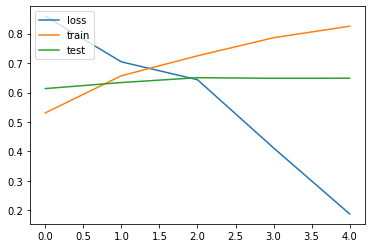

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist_loss)
plt.plot(hist_train)
plt.plot(hist_test)
plt.legend(['loss','train', 'test'], loc='upper left')
plt.show()

# 8. 결과물 테스트

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("짜증이")
            elif np.argmax(logits) == 1:
                test_eval.append("기쁨이")
            elif np.argmax(logits) == 2:
                test_eval.append("불안이")
            elif np.argmax(logits) == 3:
                test_eval.append("당황이")
            elif np.argmax(logits) == 4:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 5:
                test_eval.append("중립이")

        print(test_eval[0] + " 느껴집니다.")

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
#질문 무한반복하기! '종료' 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '종료' :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 만약에 내가 로또에 당첨된다면 난 그 돈으로 무엇을 할지 가끔 고민해본다
불안이 느껴집니다.


하고싶은 말을 입력해주세요 : 뫼비우스의 띠처럼 아이러니하게, 지겹게 흘러가는 일상이다
중립이 느껴집니다.


하고싶은 말을 입력해주세요 : 항상 행복한 순간들이 많기를 기도해본다
기쁨이 느껴집니다.


하고싶은 말을 입력해주세요 : 잠에서 깨어났지만, 눈을 뜨고 싶지 않았다
중립이 느껴집니다.


하고싶은 말을 입력해주세요 : 지각을 할 뻔했지만 지각을 하지 않았다.
기쁨이 느껴집니다.


하고싶은 말을 입력해주세요 : 인공눈물도 거의 다 써간다 돈없는데 좀 천천히 사라져주렴
중립이 느껴집니다.


하고싶은 말을 입력해주세요 : 불금인데 왜 나만 야근을 하는거야 나도 친구 생일파티 가고싶다
슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 이런 날은 집에 가는 길에도 참 찝찝하다
당황이 느껴집니다.


하고싶은 말을 입력해주세요 : 출산을 무사히 마치고 퇴원했어. 많은 사람이 축하해줬는데 그분들께 너무 감사해.
기쁨이 느껴집니다.


하고싶은 말을 입력해주세요 : 은퇴가 가까워지면서 은퇴 후 나의 모습에 대한 두려움이 있어.
불안이 느껴집니다.


하고싶은 말을 입력해주세요 : 종료


In [ ]:
#질문 무한반복하기! '종료' 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '종료' :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 어제는 아내의 생일이었다. 생일을 맞이하여 아침을 준비하겠다고 오전 8시 30분부터 음식을 준비하였다. 주된 메뉴는 스테이크와 낙지볶음, 미역국, 잡채, 소야 등이었다. 스테이크는 자주하는 음식이어서 자신이 준비하려고 했다. 앞뒤도 1분씩 3번 뒤집고 레스팅을 잘 하면 육즙이 가득한 스테이크가 준비되다. 아내도 그런 스테이크를 좋아한다. 그런데 상상도 못한 일이 벌이지고 말았다. 보통 시즈닝이 되지 않은 원육을 사서 스테이크를 했는데, 이번에는 시즈닝이 된 부채살을 구입해서 했다. 그런데 케이스안에 방부제가 들어있는 것을 인지하지 못하고 방부제와 동시에 후라이팬에 올려놓을 것이다. 그것도 인지 못한체... 앞면을 센불에 1분을 굽고 뒤집는 순간 방부제가 함께 구어진 것을 알았다. 아내의 생일이라 맛있게 구워보고 싶었는데 어처구니 없는 상황이 발생한 것이다. 방부제가 센불에 녹아서 그런지 물처럼 흘러내렸다.  고민을 했다. 방부제가 묻은 부문만 제거 하고 다시 구울까 했는데 방부제에 절대 먹지 말라는 문구가 있어서 아깝지만 버리는 방향을 했다. 너무나 안타까웠다. 아침 일찍 아내가 좋아하는 스테이크를 준비하고 그것을 맛있게 먹는 아내의 모습을 보고 싶었는데 전혀 생각지도 못한 상황이 발생해서... 하지만 정신을 추스리고 바로 다른 메뉴로 변경했다. 소야, 소세지 야채볶음... 아내가 좋아하는지 모르겠지만 냉장고 안에 있는 후랑크소세지를 보니 바로 소야를 해야 겠다는 생각이 들었다. 음식은 성공적으로 완성이 되었다. 40번째를 맞이하는 아내의 생일은 성공적으로 준비가 되었다. 맛있게 먹어 준 아내에게도 감사했다. 매년 아내의 생일에 맞이하면 아침마다 생일을 차려야 겠다. 오늘도 즐거운 하루가 되었으면 좋겠다. 생일이니까~
기쁨이 느껴집니다.


하고싶은 말을 입력해주세요 : 가입만 하고 잘 안나가던 걷기 모임에 나갔다. 거기서 처음 가는 곳을 갔다. 동작역 근처였는데 아경도 예쁘고 좋았다. 항상 가는 곳만 다녀서 이런 곳이 있는 줄도